In [6]:
import tensorflow as tf

len(tf.config.list_physical_devices('GPU') )

1

In [7]:
!pip install tensorflow_text --quiet
!pip install tf-keras --quiet
!pip install --upgrade tensorflow-hub --quiet
!pip install focal_loss --quiet

In [8]:
from tf_keras.models import load_model
from focal_loss import BinaryFocalLoss

In [9]:
import tensorflow_text as text
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras as keras

In [10]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
import json
from datasets import Dataset, DatasetDict

# hfDataset

In [15]:
datasets = DatasetDict.load_from_disk('/kaggle/input/hfdataset/hfDataset')
datasets

DatasetDict({
    train: Dataset({
        features: ['address', 'source_code', 'bytecode', 'slither', 'dataset', 'source_length', 'processed_source_code', 'abstract_source_code'],
        num_rows: 10426
    })
    test: Dataset({
        features: ['address', 'source_code', 'bytecode', 'slither', 'dataset', 'source_length', 'processed_source_code', 'abstract_source_code'],
        num_rows: 2178
    })
    validation: Dataset({
        features: ['address', 'source_code', 'bytecode', 'slither', 'dataset', 'source_length', 'processed_source_code', 'abstract_source_code'],
        num_rows: 1451
    })
})

In [16]:
df_train = datasets['train'].to_pandas()
df_test = datasets['test'].to_pandas()
df_val = datasets['validation'].to_pandas()

In [17]:
for split in [df_train, df_test, df_val]:
    split.info()
    print('-----')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10426 entries, 0 to 10425
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   address                10426 non-null  object
 1   source_code            10426 non-null  object
 2   bytecode               10426 non-null  object
 3   slither                10426 non-null  int64 
 4   dataset                10426 non-null  object
 5   source_length          10426 non-null  int64 
 6   processed_source_code  10426 non-null  object
 7   abstract_source_code   10426 non-null  object
dtypes: int64(2), object(6)
memory usage: 651.8+ KB
-----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   address                2178 non-null   object
 1   source_code            2178 non-null   object
 2   bytecode 

In [18]:
from keras.utils import to_categorical

y_train = df_train['slither'].values
y_train = to_categorical(y_train)
y_test = df_test['slither'].values
y_test = to_categorical(y_test)
y_val = df_val['slither'].values
y_val = to_categorical(y_val)

y_train.shape, y_test.shape, y_val.shape

((10426, 6), (2178, 6), (1451, 6))

# Build bert model to handle source code

In [30]:
preprocessor = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-l-12-h-768-a-12/versions/4", trainable=True)

In [31]:
text_input = keras.layers.Input(shape=(), dtype=tf.string)

# Preprocess the text with TF_HUB
encoder_inputs = preprocessor(text_input)

# Encode the processed text for BERT
outputs = encoder(encoder_inputs)

# Pool the output
pooled_output = outputs["pooled_output"]

In [32]:
x = keras.layers.Dropout(0.3)(pooled_output)
x = keras.layers.Dense(256, activation='relu')(x)

output = keras.layers.Dense(6, activation ='sigmoid', name="output")(x)

model = keras.Model(inputs = [text_input], outputs = [output])

In [33]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer_4 (KerasLayer)  {'input_word_ids': (None,    0         ['input_3[0][0]']             
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                            

In [34]:
from focal_loss import BinaryFocalLoss
model.compile(optimizer=keras.optimizers.Adam(learning_rate=2e-5), 
              loss=BinaryFocalLoss(gamma=2), 
              metrics=['accuracy'])

tf.debugging.set_log_device_placement(True)

In [15]:
df_train['source_code'] = df_train['source_code'].astype(str)
df_test['source_code'] = df_test['source_code'].astype(str)

history = model.fit(
    df_train['source_code'], y_train,
    validation_data=(df_val['source_code'], y_val),
    epochs=5,
    verbose=1,
)

model.evaluate(df_test['source_code'], y_test)   

Epoch 1/5
326/326 [==============================] - 226s 588ms/step - loss: 0.0755 - accuracy: 0.6467 - val_loss: 0.0628 - val_accuracy: 0.6878
Epoch 2/5
326/326 [==============================] - 191s 584ms/step - loss: 0.0592 - accuracy: 0.6909 - val_loss: 0.0558 - val_accuracy: 0.7085
Epoch 3/5
326/326 [==============================] - 190s 584ms/step - loss: 0.0519 - accuracy: 0.7171 - val_loss: 0.0544 - val_accuracy: 0.7216
Epoch 4/5
326/326 [==============================] - 190s 584ms/step - loss: 0.0456 - accuracy: 0.7474 - val_loss: 0.0653 - val_accuracy: 0.7202
Epoch 5/5
69/69 [==============================] - 17s 240ms/step - loss: 0.0504 - accuracy: 0.7112


[0.050442684441804886, 0.7112029194831848]

In [17]:
# Save entire model
model.save('/kaggle/working/BERT_M1.h5')

In [27]:
df_train['processed_source_code'] = df_train['processed_source_code'].astype(str)
df_test['processed_source_code'] = df_test['processed_source_code'].astype(str)

history = model.fit(
    df_train['processed_source_code'], y_train,
    validation_data=(df_val['processed_source_code'], y_val),
    epochs=5,
    verbose=1,
)

model.evaluate(df_test['processed_source_code'], y_test)   

Epoch 1/5
326/326 [==============================] - 213s 566ms/step - loss: 0.0754 - accuracy: 0.6364 - val_loss: 0.0550 - val_accuracy: 0.6968
Epoch 2/5
326/326 [==============================] - 183s 562ms/step - loss: 0.0564 - accuracy: 0.7036 - val_loss: 0.0525 - val_accuracy: 0.7092
Epoch 3/5
326/326 [==============================] - 183s 562ms/step - loss: 0.0488 - accuracy: 0.7302 - val_loss: 0.0493 - val_accuracy: 0.7229
Epoch 4/5
326/326 [==============================] - 183s 562ms/step - loss: 0.0422 - accuracy: 0.7601 - val_loss: 0.0507 - val_accuracy: 0.7319
Epoch 5/5
69/69 [==============================] - 15s 221ms/step - loss: 0.0574 - accuracy: 0.7397


[0.057419780641794205, 0.7396694421768188]

In [29]:
# Save entire model
model.save('/kaggle/working/BERT_M2.h5')

In [35]:
df_train['abstract_source_code'] = df_train['abstract_source_code'].astype(str)
df_test['abstract_source_code'] = df_test['abstract_source_code'].astype(str)

history = model.fit(
    df_train['abstract_source_code'], y_train,
    validation_data=(df_val['abstract_source_code'], y_val),
    epochs=5,
    verbose=1,
)

model.evaluate(df_test['abstract_source_code'], y_test)   

Epoch 1/5
326/326 [==============================] - 207s 549ms/step - loss: 0.0728 - accuracy: 0.6467 - val_loss: 0.0557 - val_accuracy: 0.6975
Epoch 2/5
326/326 [==============================] - 177s 545ms/step - loss: 0.0547 - accuracy: 0.7117 - val_loss: 0.0519 - val_accuracy: 0.7188
Epoch 3/5
326/326 [==============================] - 177s 543ms/step - loss: 0.0475 - accuracy: 0.7348 - val_loss: 0.0501 - val_accuracy: 0.7429
Epoch 4/5
326/326 [==============================] - 177s 543ms/step - loss: 0.0421 - accuracy: 0.7570 - val_loss: 0.0499 - val_accuracy: 0.7402
Epoch 5/5
69/69 [==============================] - 14s 204ms/step - loss: 0.0575 - accuracy: 0.7355


[0.05751366540789604, 0.7355371713638306]

In [36]:
# Save entire model
model.save('/kaggle/working/BERT_M3.h5')

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Test

In [12]:
model_m1 = load_model(
    '/kaggle/input/bert_sourcecode/keras/default/1/BERT_M1.h5',
    custom_objects={
        'KerasLayer': hub.KerasLayer,
        'BinaryFocalLoss': BinaryFocalLoss
    }
)

In [13]:
model_m2 = load_model(
    '/kaggle/input/bert_sourcecode/keras/default/1/BERT_M2.h5',
    custom_objects={
        'KerasLayer': hub.KerasLayer,
        'BinaryFocalLoss': BinaryFocalLoss
    }
)

In [14]:
model_m3 = load_model(
    '/kaggle/input/bert_sourcecode/keras/default/1/BERT_M3.h5',
    custom_objects={
        'KerasLayer': hub.KerasLayer,
        'BinaryFocalLoss': BinaryFocalLoss
    }
)

In [21]:
df_test['abstract_source_code'], y_test

(0       security_functions:\n  function approve(params...
 1       security_functions:\n  function * * Initialize...
 2       security_functions:\n  function * * Initialize...
 3       security_functions:\n  function Stop(params) p...
 4       security_functions:\n  function * * Initialize...
                               ...                        
 2173    security_functions:\n  function approve(params...
 2174    security_functions:\n  function _transfer(para...
 2175    variables:\n  IERC20 public muse = IERC20(0xB6...
 2176    security_functions:\n  function withdraw(param...
 2177    security_functions:\n  function aggregate(para...
 Name: abstract_source_code, Length: 2178, dtype: object,
 array([[0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        ...,
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.]]))

In [26]:
models = [model_m1, model_m2, model_m3]
model_names = ['Model 1', 'Model 2', 'Model 3']

In [27]:
results = []
for model in models:
    loss, acc = model.evaluate(df_test['abstract_source_code'], y_test, verbose=0)
    results.append({'loss': loss, 'accuracy': acc})

In [28]:
import pandas as pd
results_df = pd.DataFrame(results, index=model_names)
print(results_df)

             loss  accuracy
Model 1  0.079669  0.663453
Model 2  0.094664  0.607897
Model 3  0.057514  0.735537


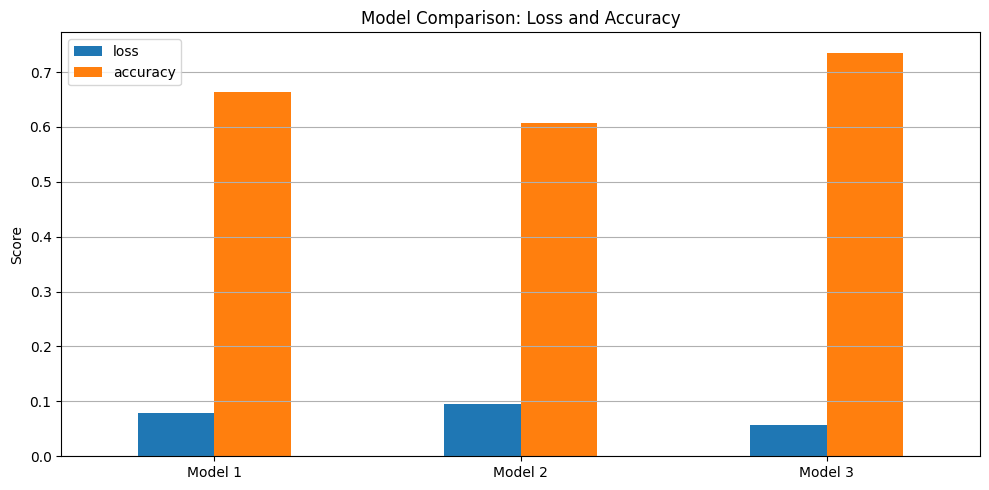

In [29]:
import matplotlib.pyplot as plt

results_df.plot(kind='bar', figsize=(10, 5))
plt.title("Model Comparison: Loss and Accuracy")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [31]:
model_m1.count_params()  # Full model config

109680647

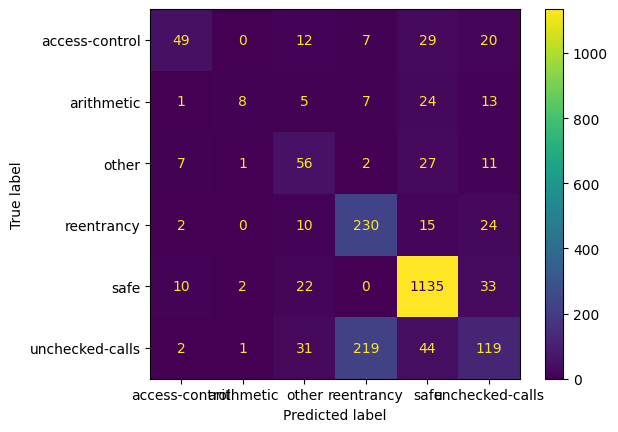

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_1, y_predicted_1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['access-control', 'arithmetic', 'other', 'reentrancy', 'safe', 'unchecked-calls']
)

cm_display.plot()
plt.show()